In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader

Using GPU!
Using GPU!
Using GPU!
No TPUs...


In [2]:
!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [3]:
writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


#cpu = torch.ones(1).device

me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)

In [4]:
u,v=lapOp.diagonalize()

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_utils/tensor.py:16: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  R = torch.cholesky(VTV, upper=True)  # (*BMV, nguess, nguess)
/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_impls/linalg/symeig.py:174: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion

In [5]:
#List layers : 
layers = [module for module in model.modules() if isinstance(module, nn.Sequential)]
for layer in layers:
    print(layer)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): FFNet(
    (linears): ModuleList(
      (0): Linear(in_features=784, out_features=50, bias=False)
      (1): Linear(in_features=50, out_features=50, bias=False)
      (2): Linear(in_features=50, out_features=10, bias=False)
    )
  )
)


# Spectrum with no training 

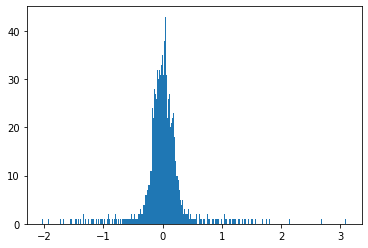

In [6]:
u = u.to('cpu')
plt.hist(u.numpy(),bins=300)
plt.show()

# Training the model 

In [7]:

optimizer = torch.optim.SGD
pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5)

Epoch 1
-------------------------------
Epoch training loss: 0.920632 	Epoch training accuracy: 72.91%                                      00 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 89.15%,                 Avg loss: 0.387883 



(0.387883287191391, 89.14999999999999)

# Spectrum after training 

In [8]:
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)
uTrained,vTrained = lapOp.diagonalize()

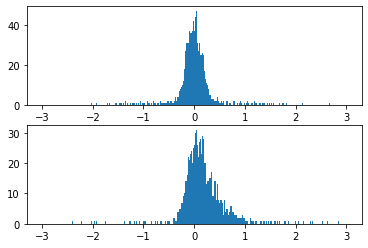

In [9]:
uTrained = uTrained.to('cpu')
plt.figure(1)
plt.subplot(211)
plt.hist(u.numpy(),bins=300,range=(-3,3))
plt.subplot(212)
plt.hist(uTrained.numpy(),bins=300,range=(-3,3))
plt.show()

# Spectrum evolution

Epoch 1
-------------------------------
Epoch training loss: 0.964805 	Epoch training accuracy: 73.30%                                      0 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.91%,                 Avg loss: 0.387240 

Epoch 1
-------------------------------
Epoch training loss: 0.344104 	Epoch training accuracy: 89.94%                                                                
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.04%,                 Avg loss: 0.307294 

Epoch 1
-------------------------------
Epoch training loss: 0.279185 	Epoch training accuracy: 91.82%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 92.44%,                 Avg loss: 0.263019 



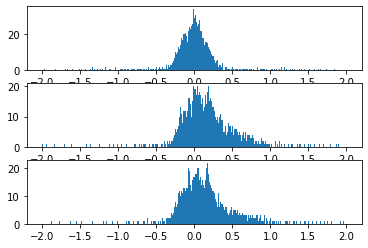

In [10]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=True))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 2


plt.figure(1)
epochs=epochs+1
for i in range(epochs):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights)
    u,v = lapOp.diagonalize()
    plt.subplot(100*epochs + 11+i)
    plt.hist(u.to('cpu').numpy(),bins=300,range=(-2,2))
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(-0.0119, device='cuda:0')


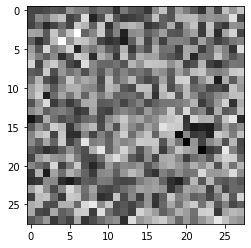

In [11]:
#Plotting eigenvectors 
idx = 6

img =-v.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')


print(u[285])

# With absolute value : 

Epoch 1
-------------------------------
Epoch training loss: 0.928584 	Epoch training accuracy: 73.06%                                                               
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.15%,                 Avg loss: 0.403165 

Epoch 1
-------------------------------
Epoch training loss: 0.343126 	Epoch training accuracy: 90.15%                                      00 ]                      
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.22%,                 Avg loss: 0.302290 



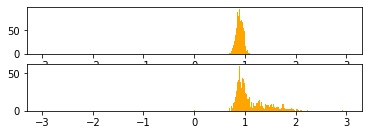

In [12]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='abs')
    uabs,vabs = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(uabs.to('cpu').numpy(),bins=300,range=(-3,3),color='orange')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(25.4082, device='cuda:0')


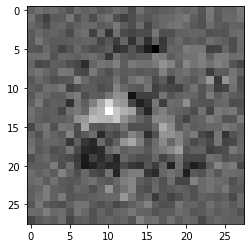

In [13]:
#Plotting eigenvectors 
idx = -8
print(uabs[idx])

img = vabs.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')



# With ReLU

Epoch 1
-------------------------------
Epoch training loss: 0.937970 	Epoch training accuracy: 73.59%                                      00 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.41%,                 Avg loss: 0.409019 

Epoch 1
-------------------------------
Epoch training loss: 0.346645 	Epoch training accuracy: 90.00%                                      00 ]                      
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.22%,                 Avg loss: 0.299756 



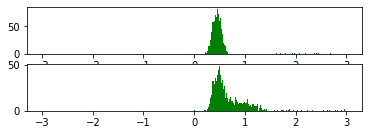

In [14]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='relu')
    urelu,vrelu = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(urelu.to('cpu').numpy(),bins=300,range=(-3,3),color='green')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(1.7517, device='cuda:0')
torch.Size([894, 894])
tensor([-0.0403, -0.0596, -0.0590, -0.0259, -0.0397,  0.0019, -0.0628, -0.0452,
        -0.0709, -0.0207], device='cuda:0')


tensor(5, device='cuda:0')

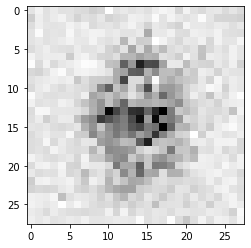

In [15]:
#Plotting eigenvectors 
idx = 789
print(urelu[idx])

img = vrelu.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

print(vrelu.shape)
print(-vrelu.T[idx][-10:])
(-vrelu.T[idx][-10:]).argmax()

In [16]:
torch.argmax(torch.abs(vrelu.T[-5][:10]))

tensor(6, device='cuda:0')

# High spectrum tests

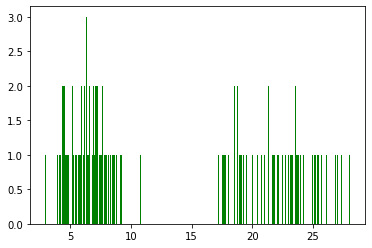

In [17]:
plt.hist(uabs.to('cpu')[28*28:].numpy(),bins=300,color='green')
plt.show()

In [18]:
import time 
#Plotting eigenvectors 
idx = 888
print(uabs[idx])


def saveEigenImages():
    i=28*28
    while i <893:
        idx = i 
        if vabs.T[idx][:28*28].mean()<(vabs.T[idx][:28*28].max()+vabs.T[idx][:28*28].min())/2:
            vabs.T[idx]=-vabs.T[idx]
        img = vabs.T[idx][:28*28].to('cpu')
        pixels = img.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.savefig('lapInputLayer' + "/eigenVec%02d.png" % idx)
        plt.show()

        i +=1 


tensor(25.7464, device='cuda:0')


In [19]:
!ls

basic_tutorial_gridsearch_benchmarking.ipynb  Intersection_Homology.ipynb
basic_tutorial_image.ipynb		      kernelAnalysis.ipynb
basic_tutorial_QandA.ipynb		      lapInputLayer
basic_tutorial_regression.ipynb		      lapInputLayerBin
basic_tutorial_tabular.ipynb		      lapInputLayer.zip
basic_tutorial_textClass.ipynb		      LaplacianSpectralAnalysis.ipynb
basic_tutorial_translation.ipynb	      optimising_topology.ipynb
compactification.ipynb			      orbit_5k_train.ipynb
data					      runs
decision_boundary_tori.ipynb		      spectral_analysis_cnn.ipynb
Ensemble_learning.ipynb			      TopactivationFC_tutorial.ipynb


# Binary mode

In [20]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from gdeep.data import DataLoaderFromArray
from torch.utils.data import DataLoader, random_split


writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")

dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


dataset = datasets.MNIST(root='./data',transform=ToTensor())
idx  = torch.logical_or(dataset.targets==4,dataset.targets==6)
dataset.targets = ((dataset.targets[idx]-4)/2).int()
dataset.data = dataset.data[idx]


my_dl = DataLoader(dataset)


train_len = int(len(dataset)*5/6)
train_set, test_set = random_split(dataset, [train_len, int(len(dataset)) - train_len])

dl_tr2 = DataLoader(train_set, batch_size=32, shuffle=True) # Train dataloader
dl_ts2 = DataLoader(test_set, batch_size=32, shuffle=False) # Test set 


""" Crappy stuff 
j = int(len(data)*5/6) 
print(data.type())


dl2 = DataLoaderFromArray(data[:j].unsqueeze(1),targets[:j],X_val=data[j:].unsqueeze(1),y_val=targets[j:])
dl_tr2, dl_ts2,_ = dl2.build_dataloaders(batch_size=32)



#dl_tr2.dataset = [(x[0],int(x[1].item())) for x in dl_tr2.dataset]
    
#dl_ts2.dataset = [(x[0],int(x[1].item())) for x in dl_ts2.dataset]

print(len(dl_tr),len(dl_ts))
print(len(dl_tr2),len(dl_ts2))
"""

' Crappy stuff \nj = int(len(data)*5/6) \nprint(data.type())\n\n\ndl2 = DataLoaderFromArray(data[:j].unsqueeze(1),targets[:j],X_val=data[j:].unsqueeze(1),y_val=targets[j:])\ndl_tr2, dl_ts2,_ = dl2.build_dataloaders(batch_size=32)\n\n\n\n#dl_tr2.dataset = [(x[0],int(x[1].item())) for x in dl_tr2.dataset]\n    \n#dl_ts2.dataset = [(x[0],int(x[1].item())) for x in dl_ts2.dataset]\n\nprint(len(dl_tr),len(dl_ts))\nprint(len(dl_tr2),len(dl_ts2))\n'

In [21]:
for x in dl_ts2.dataset:
    print(x[0].type())
    break 

torch.FloatTensor


Epoch 1
-------------------------------
Epoch training loss: 0.560479 	Epoch training accuracy: 88.06%                                       ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.42%,                 Avg loss: 0.145162 

Epoch 1
-------------------------------
Epoch training loss: 0.062141 	Epoch training accuracy: 98.61%                                      45 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.47%,                 Avg loss: 0.044706 

Epoch 1
-------------------------------
Epoch training loss: 0.035486 	Epoch training accuracy: 98.93%                                      45 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.98%,                 Avg loss: 0.037565 

Epoch 1
-------------------------------
Epoch training loss: 0.031010 	Epoch t

Validation results: 
 Accuracy: 99.80%,                 Avg loss: 0.009630 

Epoch 1
-------------------------------
Epoch training loss: 0.008028 	Epoch training accuracy: 99.81%                                      45 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.80%,                 Avg loss: 0.004805 

Epoch 1
-------------------------------
Epoch training loss: 0.006957 	Epoch training accuracy: 99.83%                                      5 ]                       
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.80%,                 Avg loss: 0.007135 

Epoch 1
-------------------------------
Epoch training loss: 0.006855 	Epoch training accuracy: 99.83%                                      5 ]                       
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.80%,                 Avg loss: 0.005729

Epoch training loss: 0.000331 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000301 

Epoch 1
-------------------------------
Epoch training loss: 0.000320 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000318 

Epoch 1
-------------------------------
Epoch training loss: 0.000305 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000316 

Epoch 1
-------------------------------
Epoch training loss: 0.000288 	Epoch training accuracy: 100.00%                                        

Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000148 

Epoch 1
-------------------------------
Epoch training loss: 0.000162 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000201 

Epoch 1
-------------------------------
Epoch training loss: 0.000156 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000229 

Epoch 1
-------------------------------
Epoch training loss: 0.000160 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000185 

Epoch 1
-----------------

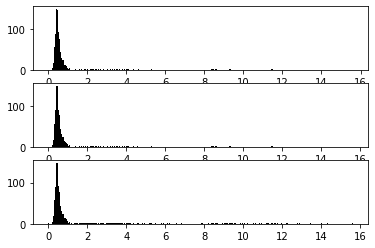

In [22]:


arch = [28*28, 50, 50, 50, 2]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr2, dl_ts2), loss_fn, writer)


epochs = 3
overfit = True


if overfit:
    for epoch in range(150):
         pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)

plt.figure(1)
for i in range(epochs):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='relu')
    ubin,vbin = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(ubin.to('cpu').numpy(),bins=300,color='black')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

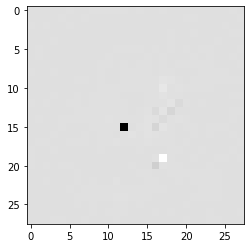

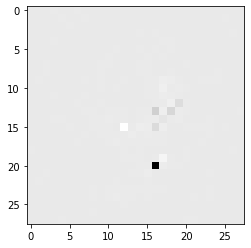

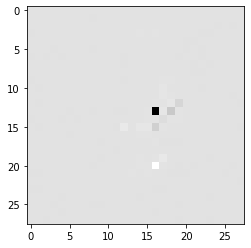

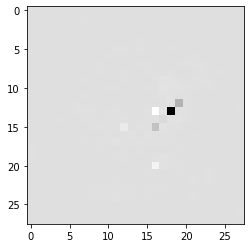

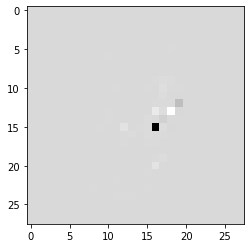

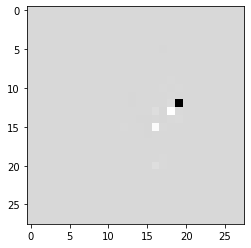

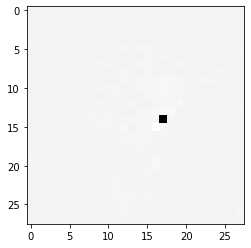

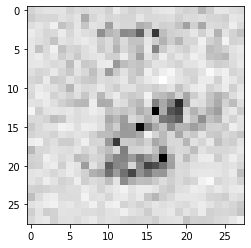

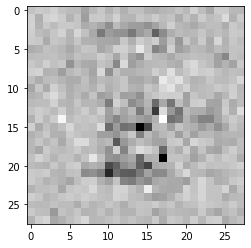

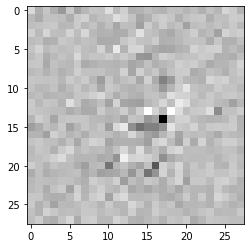

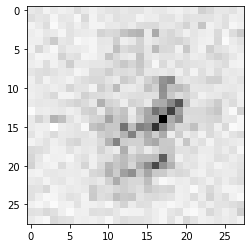

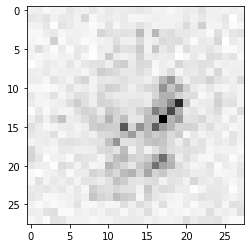

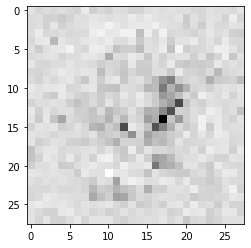

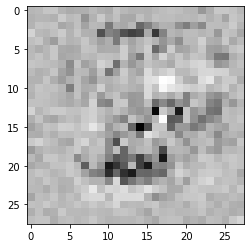

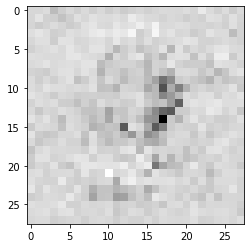

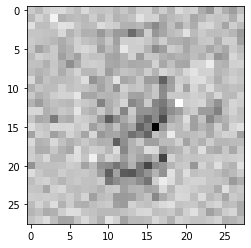

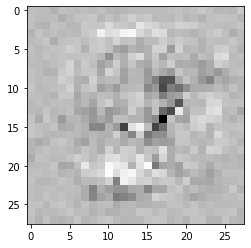

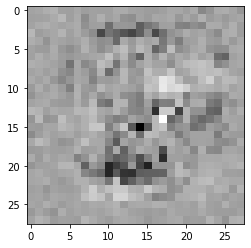

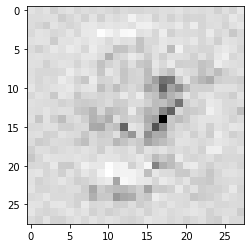

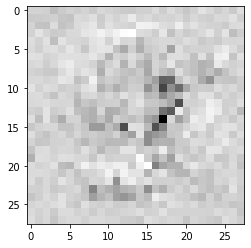

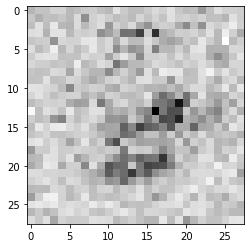

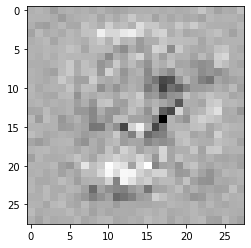

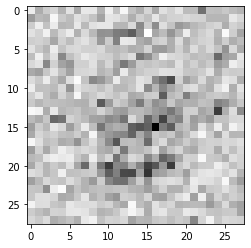

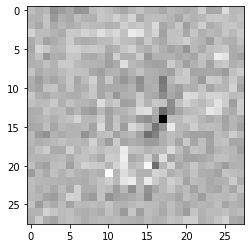

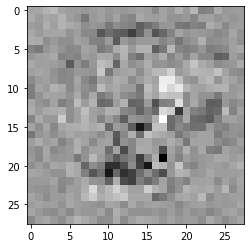

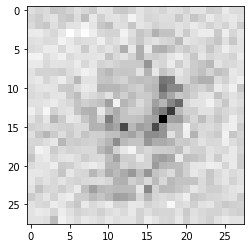

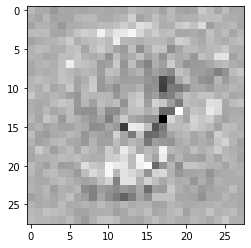

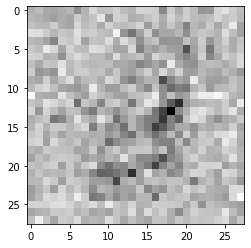

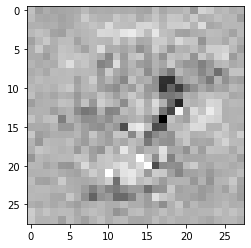

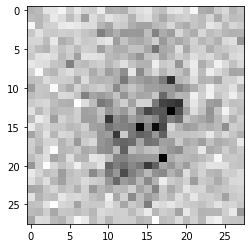

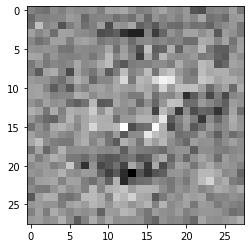

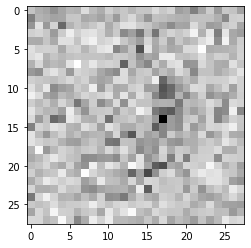

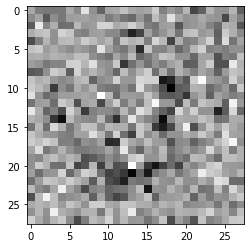

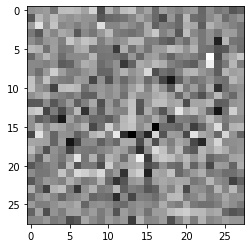

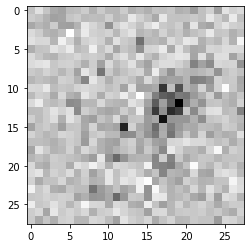

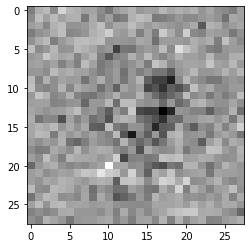

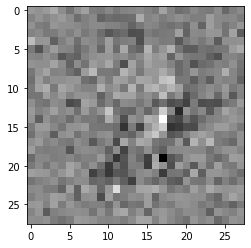

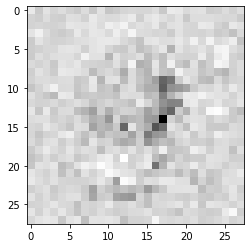

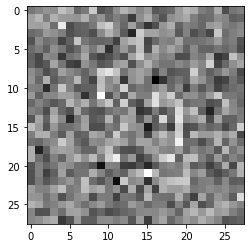

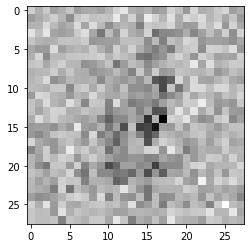

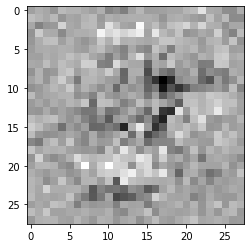

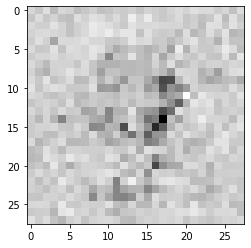

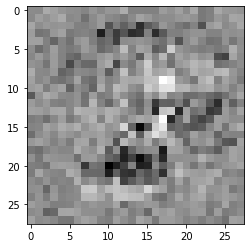

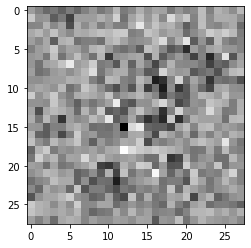

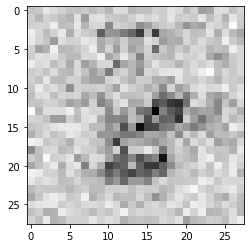

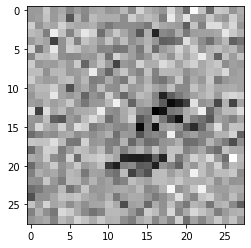

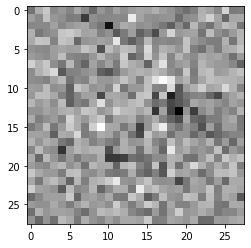

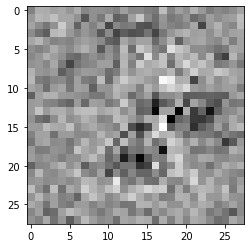

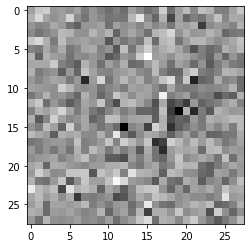

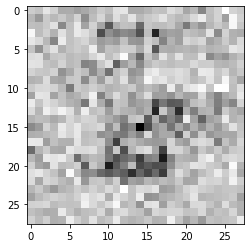

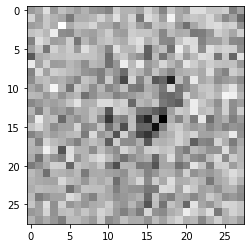

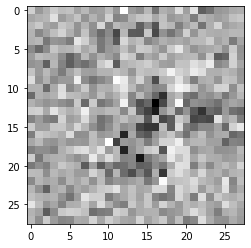

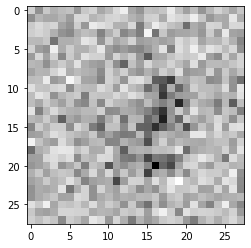

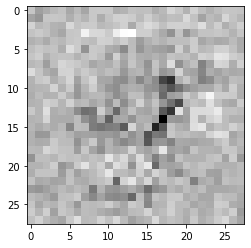

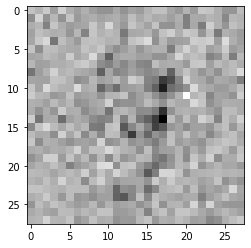

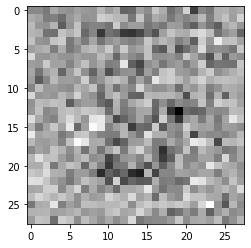

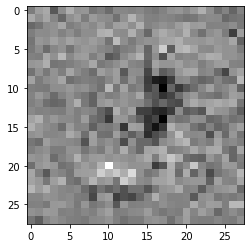

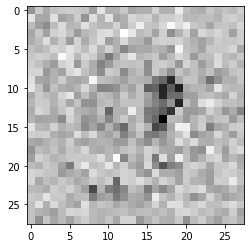

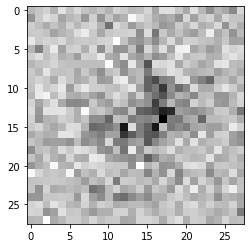

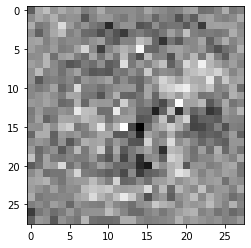

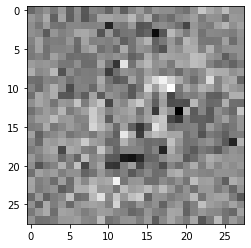

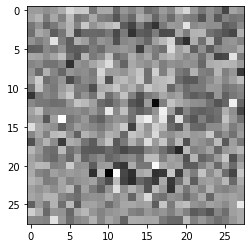

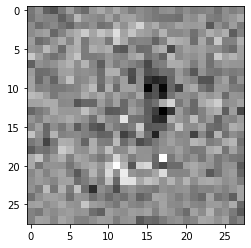

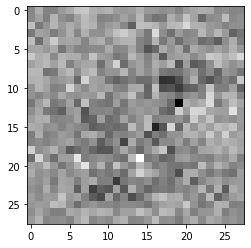

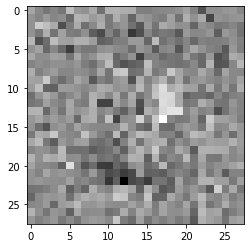

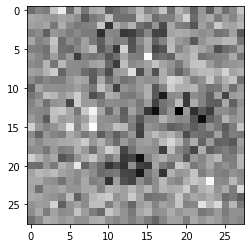

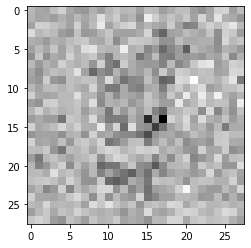

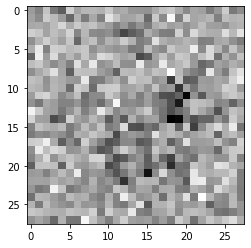

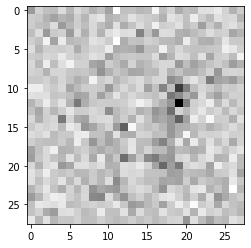

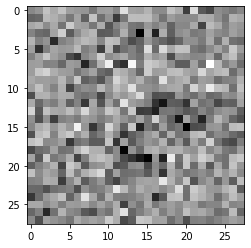

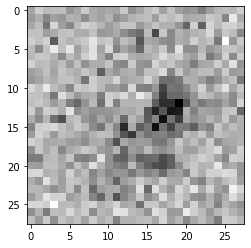

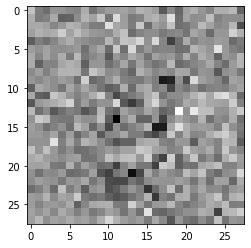

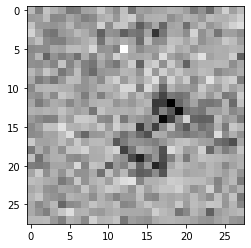

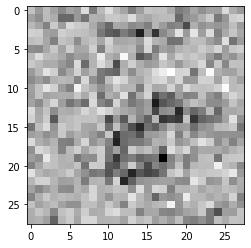

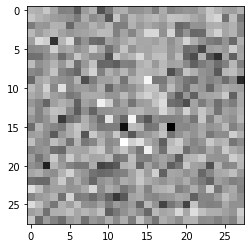

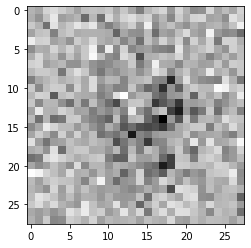

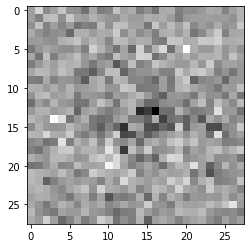

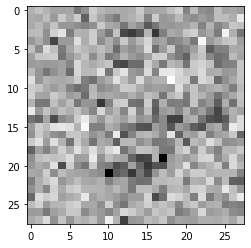

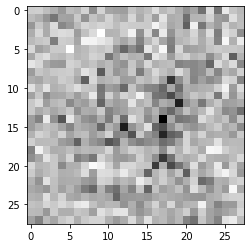

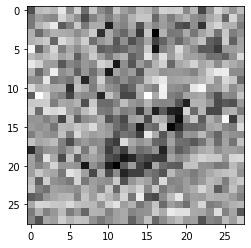

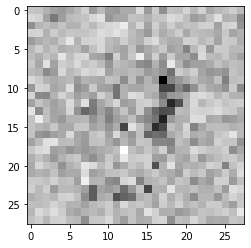

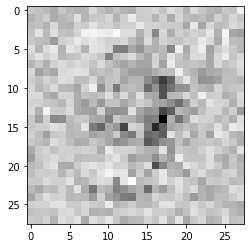

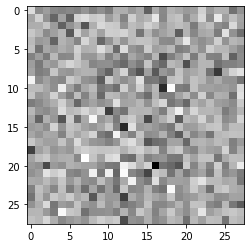

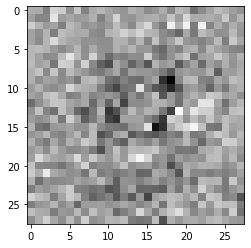

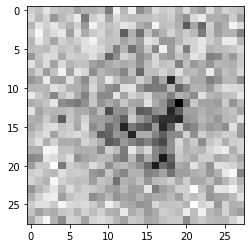

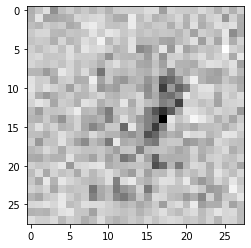

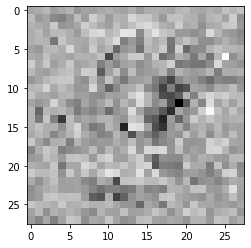

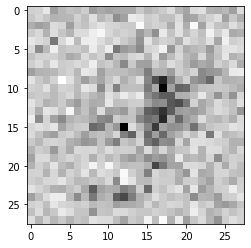

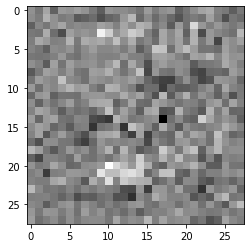

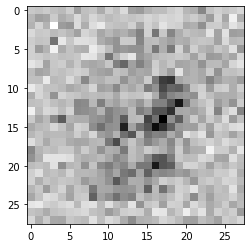

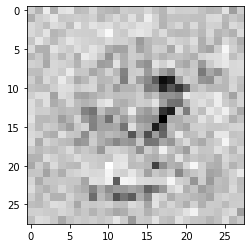

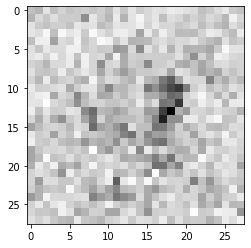

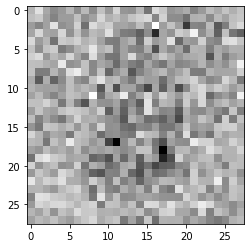

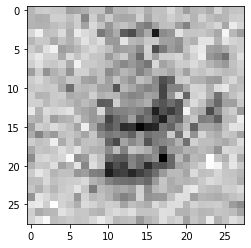

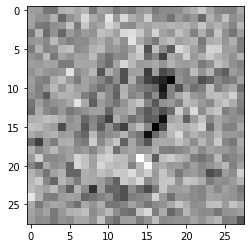

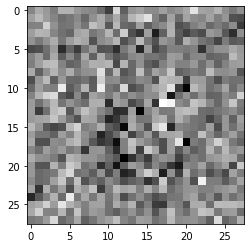

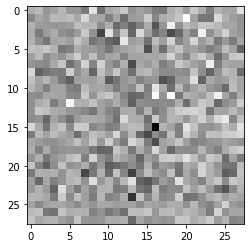

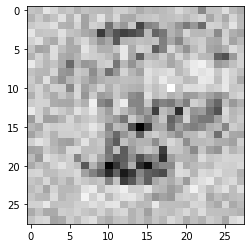

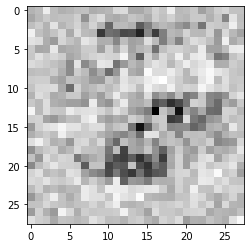

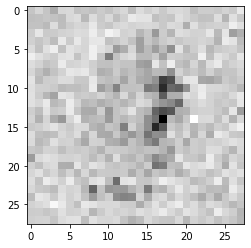

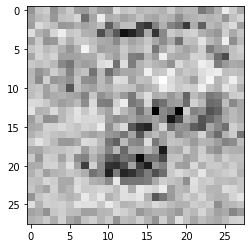

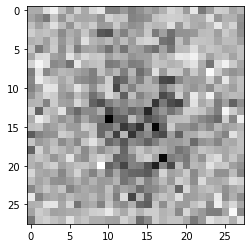

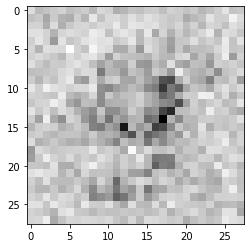

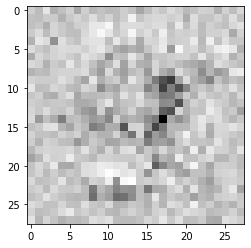

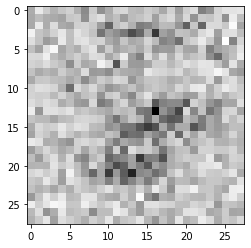

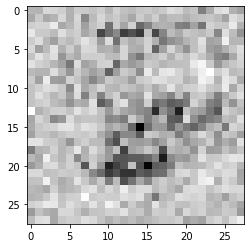

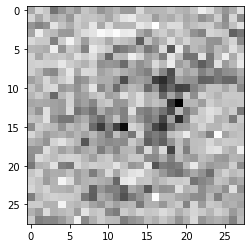

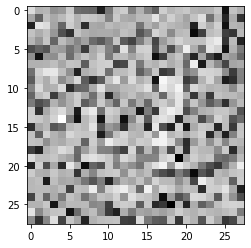

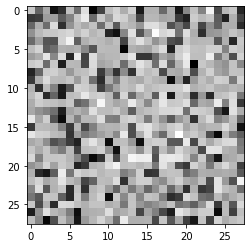

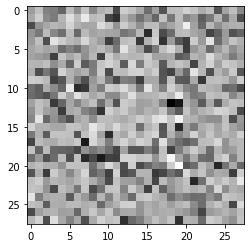

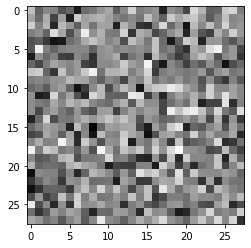

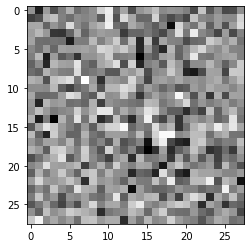

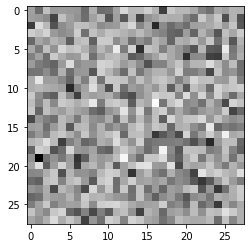

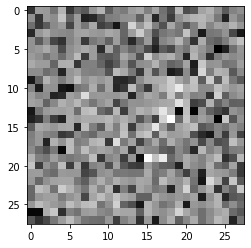

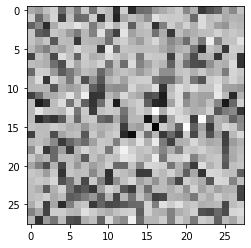

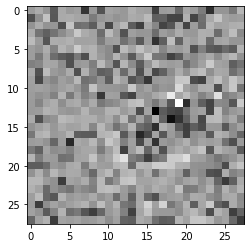

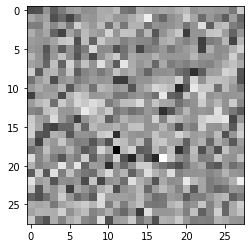

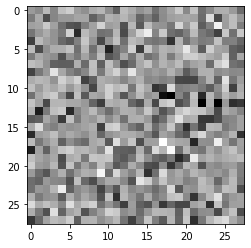

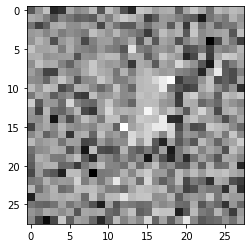

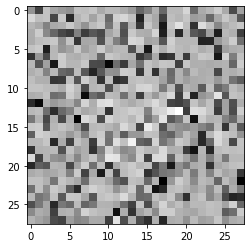

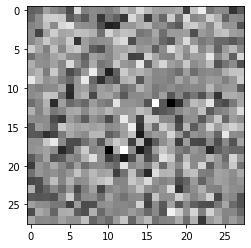

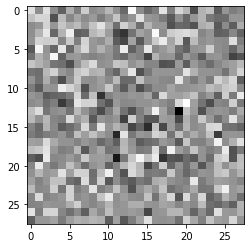

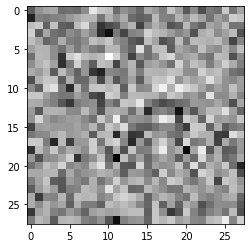

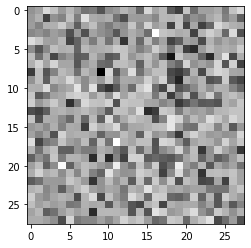

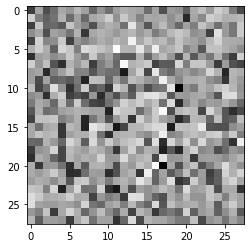

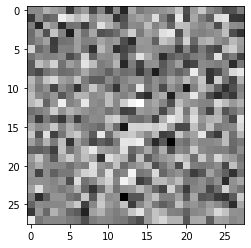

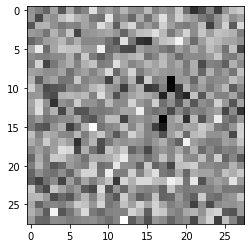

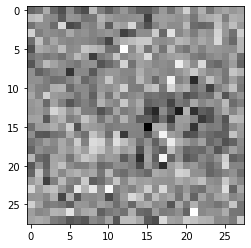

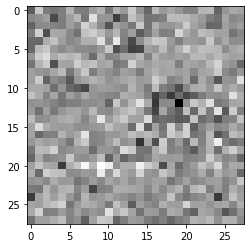

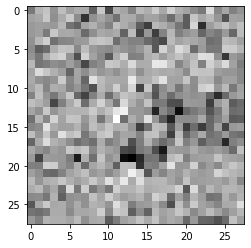

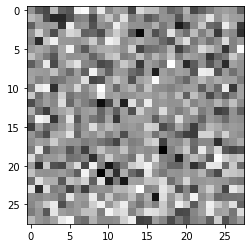

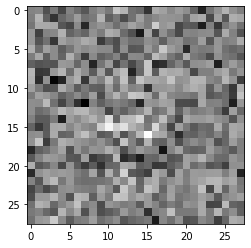

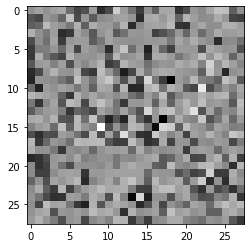

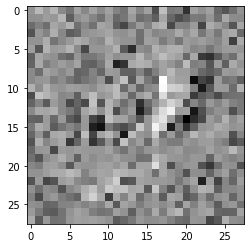

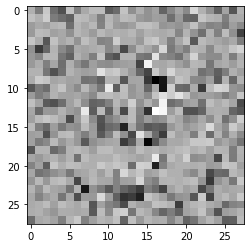

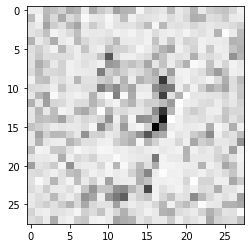

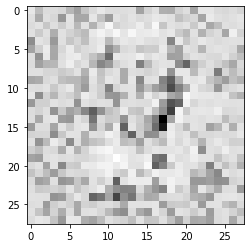

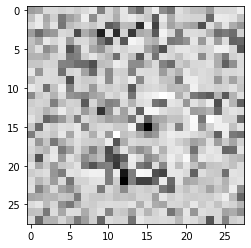

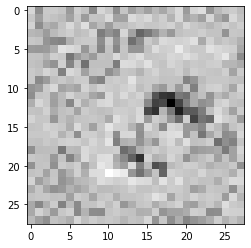

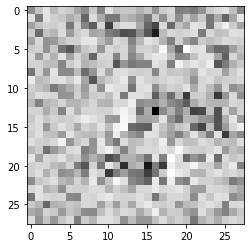

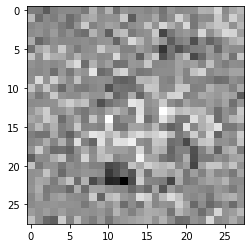

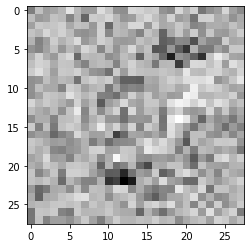

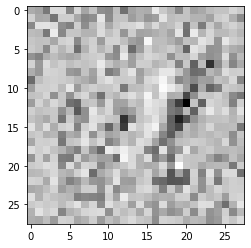

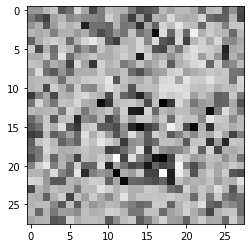

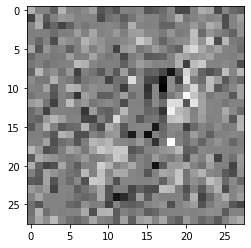

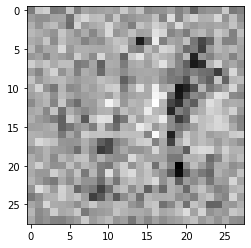

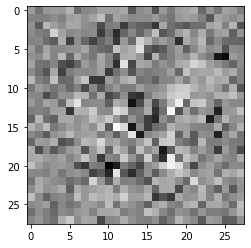

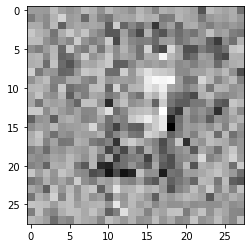

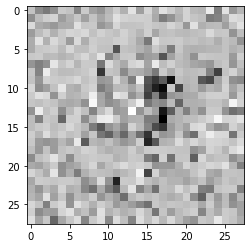

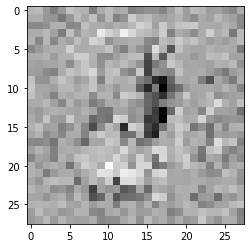

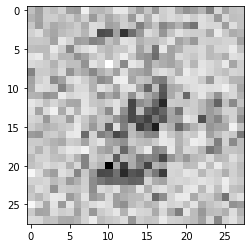

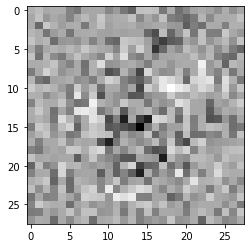

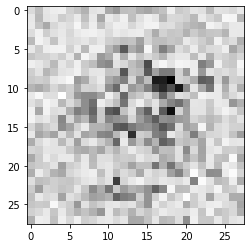

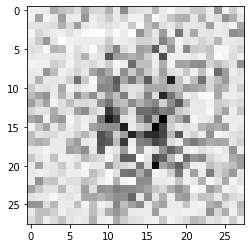

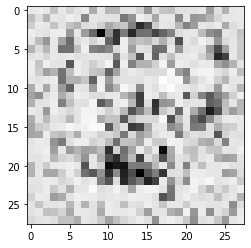

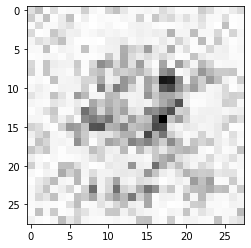

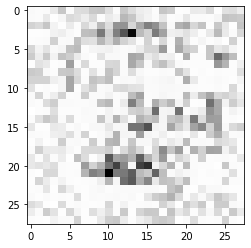

In [23]:
def saveEigenImages2():
    i=28*28-5
    while i <len(vbin.T):
        idx = i 
        if vbin.T[idx][:28*28].mean()<(vbin.T[idx][:28*28].max()+vbin.T[idx][:28*28].min())/2:
            vbin.T[idx]=-vbin.T[idx]
        img = vbin.T[idx][:28*28].to('cpu')
        pixels = img.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.savefig('lapInputLayerBin' + "/eigenVec%02d.png" % idx)
        plt.show()

        i +=1 

saveEigenImages2()

tensor(2.2490, device='cuda:0')
tensor([-0.0483, -0.2725, -0.0032,  0.0655, -0.0198,  0.0057,  0.4656, -0.0101,
         0.0025, -0.0015], device='cuda:0')


tensor(6, device='cuda:0')

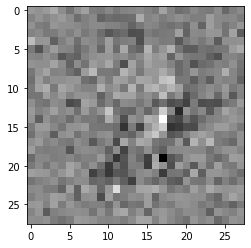

In [24]:
#Plotting eigenvectors 
idx = 815
print(ubin[idx])
img = vbin.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
print(-vbin.T[idx][-10:])
(-vbin.T[idx][-10:]).argmax()



    

In [25]:
vbin.T[28*28+25][872]


tensor(-0.0309, device='cuda:0')

# Getting to know the eigenvectors : metrics 

- sign 
- Total entropy 
- Argmax 
- value at argmax 
- spatial correlations on input 

In [26]:
def positivise(v):
    """Transforme le signe de chaque colonne de la matrice v de sorte à ce que l'argmax soit de signe positif """
    res = torch.zeros(v.shape)
    for idx in range(len(v.T)):
        res[:,idx]=torch.sign(v.T[idx][torch.abs(v.T[idx]).argmax()])*v.T[idx]
    return res 
        
def sign(vec):
    """Détermine la fraction de signes - pour un vecteur propre vec"""
    return (torch.relu(-torch.sign(vec)).sum())/len(vec)

def maxValue(vec):
    return vec.max()

def argMax(vec):
    return vec.argmax()

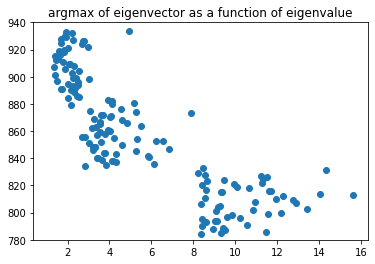

In [27]:
vbin = positivise(vbin)
vbin=vbin.to('cpu')
ubin = ubin.to('cpu')
plt.scatter(ubin[28*28:],[argMax(vec) for vec in vbin.T[28*28:]])
plt.title('argmax of eigenvector as a function of eigenvalue')
plt.ylim(780,940)
plt.show()

Text(0.5, 1.0, 'maximum value of eigenvector as a function of eigenvalue')

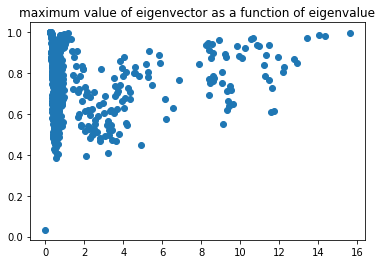

In [28]:
plt.scatter(ubin,[maxValue(vec) for vec in vbin.T])
plt.title('maximum value of eigenvector as a function of eigenvalue')

# Attaques adversariales 

## Training the model 

In [29]:
def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')

In [30]:
loss_fn

CrossEntropyLoss()

In [ ]:
arch = [28*28, 50,50,50, 10]
optimizer = torch.optim.SGD
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 15


for i in range(epochs):
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    
    
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights,positivation='relu')
u,v = lapOp.diagonalize()


def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')


Epoch 1
-------------------------------
Epoch training loss: 1.271687 	Epoch training accuracy: 59.15%                                      0 ]                       
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 86.62%,                 Avg loss: 0.452706 

Epoch 1
-------------------------------
Epoch training loss: 0.375998 	Epoch training accuracy: 88.83%                                                                
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 90.21%,                 Avg loss: 0.330413 

Epoch 1
-------------------------------
Epoch training loss: 0.286249 	Epoch training accuracy: 91.51%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 92.89%,                 Avg loss: 0.246700 

Epoch 1
-------------------------------
Epoch training loss: 0.229051 	Ep

In [ ]:
#Change the type of laplacian used

me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights,positivation='none')
u,v = lapOp.diagonalize()

In [ ]:
plt.hist(u.to('cpu').numpy(),bins=300,color='orange')
plt.show()


## Building the dataset

In [ ]:
epsilon = 0.5
n_batch = 300 #Number of batch used to generate the dataset 
activ = torch.zeros((3,n_batch*32,len(u)))
#final tensor activ[alter][idx] contains an activation vector for data sample idx with a specific alteration :
# 0 : no alteration, raw data 
# 1 : data + adversarial  noise
# 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
label = torch.zeros(n_batch*32)


topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

k_batch = 0 
for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    data_noised = torch.zeros(32,1,28,28).to(DEVICE)
    for i in range(32):
        indices=torch.randperm(784).to(DEVICE)
        data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
    
    
    normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    
    activ[0][k_batch*32:(k_batch+1)*32]=normal_activation
    activ[1][k_batch*32:(k_batch+1)*32]=perturbed_activation
    activ[2][k_batch*32:(k_batch+1)*32]=noised_activation
    label[k_batch*32:(k_batch+1)*32]=target
    
    k_batch+=1
    if k_batch>=n_batch:
        break 

In [ ]:
print28x28tensor(activ[1][0][:28*28])

In [ ]:
(data[0].to('cpu')-activ[0][0][:28*28].reshape(1,28,28)).norm()

In [ ]:
print28x28tensor(data[2].detach().reshape(784))

In [ ]:
pipe.model(activ[0][2][:28*28].reshape(1,28,28).to(DEVICE)).argmax()

In [ ]:
model(data[1].to('cpu')).argmax()

### Warning : this codes selects one specific class

In [ ]:
idxs = label==0

activ=activ[:,idxs,:]

In [ ]:
activ.shape

## Global statistics 

### Average per layer

In [ ]:
activ.mean()

In [ ]:
# Choix de l'index de l'input 
idx = 10

arch2 = arch[:-1]
avg = torch.zeros(3,len(arch2))
std = torch.zeros(3,len(arch2))
# Moyenne sur tous les neurones d'une même couche 

for alter in range(3):
    currentNode = 0
    for i,layerSize in enumerate(arch2):
        avg[alter][i] = activ[alter,idx,currentNode:(currentNode+layerSize)].mean()
        std[alter][i] = activ[alter,idx,currentNode:(currentNode+layerSize)].std()
        currentNode=currentNode+layerSize


plt.errorbar(range(len(arch2)),avg[0],yerr=std[0],color='green',label='normal')
plt.errorbar(range(len(arch2)),avg[1],yerr=std[1],color='blue',label='attacked')
plt.errorbar(range(len(arch2)),avg[2],yerr=std[2],color='orange',label='noised')
plt.legend()
plt.show()

In [ ]:
activ[0][0][-10:]

### PCA

In [ ]:
torch.cat([activ[0],activ[1]]).shape

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X= pca.fit_transform(torch.cat([activ[0],activ[1]]))
Xattacked=pca.transform(activ[1])
Xnoised=pca.transform(activ[2])
plt.scatter(X[:,0],X[:,1])
plt.scatter(Xattacked[:,0],Xattacked[:,1])
#plt.scatter(Xnoised[:,0],Xnoised[:,1])

In [ ]:
print(np.dot((activ[1].numpy()-pca.mean_),pca.components_[0].T))
print(Xattacked[:,0])

In [ ]:
plt.plot(pca.components_[0])
plt.plot(pca.components_[1])

#print(activ[0].numpy()@pca.components_[0].mean(),activ[0].numpy()@pca.components_[0].mean())

- Interpretation : nothing surprising, the PCA uses the last part of the activation to distinguish number classes which explains why adversarial examples fall in the middle. 
- When trained on one class only, the second pca component listens to intermediate neurons

### Laplacian statistics

In [ ]:
# change basis to laplacian eigenvectors 
activL = torch.zeros((3,activ.shape[1],len(u))).to(DEVICE)
activ= activ.to(DEVICE)
for alter in range(3):
    activL[alter]=activ[alter]@v
activL=activL.to('cpu')

In [ ]:
#Mean activation over each laplacian eigenvector in order 
u = u.to('cpu')
plt.scatter(u,torch.abs(activL[0]).mean(dim=0),color='green')
plt.scatter(u,torch.abs(activL[1]).mean(dim=0),color='blue')
plt.scatter(u,torch.abs(activL[2]).mean(dim=0),color='orange')

In [ ]:
print("Activation normale moyenne : ",torch.abs(activ[0]).mean(dim=1).mean().item(), "std :" , torch.abs(activ[0]).mean(dim=1).std().item() )
print("Activation adversariale moyenne :", torch.abs(activ[1]).mean(dim=1).mean().item(), "std :" , torch.abs(activ[1]).mean(dim=1).std().item() )


- Interpretation : The L1 norm of the activation is not sufficient for statistical detection of fgsm attacks (significant overlap of uncertainty zones)

In [ ]:
#Without the 0 eigenvalue
plt.scatter(u[1:],torch.abs(activL[0]).mean(dim=0)[1:],color='green')
plt.scatter(u[1:],torch.abs(activL[2]).mean(dim=0)[1:],color='orange')
plt.scatter(u[1:],torch.abs(activL[1]).mean(dim=0)[1:],color='blue')

In [ ]:
v=v.to('cpu')
plt.plot(v.T[-5])

In [ ]:
u[1]

In [ ]:
#Without the 0 eigenvalue, no absolute value 





plt.scatter(u[1:],(activL[2]).mean(dim=0)[1:],color='orange')
plt.scatter(u[1:],(activL[0]).mean(dim=0)[1:],color='green')
plt.scatter(u[1:],(activL[1]).mean(dim=0)[1:],color='blue')



In [ ]:
idx = (activL[0].mean(dim=0)).argmin()
print(idx)
print(u[idx])
print28x28tensor(v.T[idx][:28*28])

In [ ]:
plt.plot(v.T[idx].to('cpu'))

The advserial activation seems to be lower, maybe this an overall scalar effect. We will try to correct it using the factor induced by the 0 eigenvalue ratio

In [ ]:
avgNormal = torch.abs((activL[0]).mean(dim=0))
avgPerturbed = torch.abs((activL[1]).mean(dim=0))
avgNoised = torch.abs((activL[2]).mean(dim=0))

plt.scatter(u[1:],avgNormal[1:],color='green')
plt.scatter(u[1:],avgNoised[1:],color='orange')
plt.scatter(u[1:],avgNormal[0]/avgPerturbed[0]*avgPerturbed[1:],color='blue')


In [ ]:
print('L1 sum ratio',avgNormal[0]/avgPerturbed[0])
print(' cheeger coeff ratio', avgNormal[1]/avgPerturbed[1])
print('second eigenvector proj ratio', avgNormal[2]/avgPerturbed[2])
print('custom idx ratio',idx,avgNormal[idx]/avgPerturbed[idx])
print('overall norm ratio', avgNormal.norm()/avgPerturbed.norm())

In [ ]:
#scatter plot of the same thing 
idx = 40
plt.scatter(avgNoised[idx:],avgPerturbed[idx:],color='green')
plt.scatter(avgNoised[:idx],avgPerturbed[:idx],color='black')
plt.scatter(avgNoised[:idx],avgPerturbed[:idx],color='black')
#plt.scatter(avgNoised,avgNormal,color='orange')
x = np.arange(avgNoised.min(),avgNoised.max(),step=1/100)
plt.plot(x,x,label='y=x',color='grey')
plt.plot(x,x/2,label='y=x/2',color='lightgreen')
plt.legend()
print(u[idx])

In [ ]:
print(avgNoised[33])
avgPerturbed[33]

Some eigenprojections get halved (above a certain threshold) 

In [ ]:
v=v.to('cpu')
for i in range(38):
    plt.plot(v.T[i])
    print('Layer :',(torch.abs(v.T[i]).argmax()-28*28)/50)

In [ ]:
v=v.to('cpu')
for i in range(38,100):
    plt.plot(v.T[i])

In [ ]:
idx = 50 #28*28+50
activ = activ.to('cpu')
plt.scatter(activ[2].mean(dim=0)[idx:],activ[1].mean(dim=0)[idx:],color='green')
plt.scatter(activ[2].mean(dim=0)[:idx],activ[1].mean(dim=0)[:idx],color='black')
x = np.arange(activ[2].mean(dim=0).min(),activ[2].mean(dim=0).max(),step=1/100)
plt.plot(x,x,label='y=x',color='grey')
plt.plot(x,x/2,label='y=x/2',color='lightgreen')
plt.legend()



In [ ]:
plt.plot(v.T[1].to('cpu')) # Cheeger vector 
print(u[1])

In [ ]:
print28x28tensor(v.T[1][:28*28])
print(u[1])

In [ ]:
fiedlerInput = v.T[1][:28*28].reshape(1,28,28)


In [ ]:
model

In [ ]:
me.get_activations(-fiedlerInput)

### Cheeger projection analysis 
We investigate wether the projection on the Fiedler vector discriminates statistically attacks from normal observations

In [ ]:
idx = 1

cheegerCoeffNormal = activL[0,:,idx].reshape(1,activL.shape[1])
cheegerCoeffPerturbed = activL[1,:,idx].reshape(1,activL.shape[1])
cheegerCoeffNoised = activL[2,:,idx].reshape(1,activL.shape[1])
plt.hist(cheegerCoeffNormal,facecolor='g')
plt.hist(cheegerCoeffPerturbed,facecolor='b')
plt.hist(cheegerCoeffNoised,facecolor='orange')
plt.show()

### Cumulative spectrum distribution analysis

In [ ]:
(u-torch.tensor(sorted(u))).norm()

In [ ]:
avgNormal.shape

In [ ]:
csNormal = torch.cumsum(avgNormal[1:],0)
csPerturbed = torch.cumsum(avgPerturbed[1:],0)
csNoised = torch.cumsum(avgNoised[1:],0)

plt.plot(u[1:],csNormal,color='green')
plt.plot(u[1:],csNoised,color='orange')
plt.plot(u[1:],csPerturbed,color='blue')
plt.show()

In [ ]:
# Looking at the second moment 
avgNormal2 = torch.abs((activL[0]**2).mean(dim=0))
avgPerturbed2 = torch.abs((activL[1]**2).mean(dim=0))
avgNoised2 = torch.abs((activL[2]**2).mean(dim=0))

csNormal2 = torch.cumsum(avgNormal2[1:],0)
csPerturbed2 = torch.cumsum(avgPerturbed2[1:],0)
csNoised2 = torch.cumsum(avgNoised2[1:],0)

plt.plot(u[1:],csNormal2,color='green')
plt.plot(u[1:],csNoised2,color='orange')
plt.plot(u[1:],csPerturbed2,color='blue')
plt.show()



# Adversarial attacks gradient spectral analysis

<span style="color:red">WARNING : Adding bias to model to compute loss gradient per neuron </span>.
### Building the gradient dataset

In [ ]:
arch = [28*28, 50, 50, 50,50,50,50, 10]
optimizer = torch.optim.SGD
model2 = nn.Sequential(nn.Flatten(), FFNet(arch,bias=True )).to(DEVICE)
pipe2 = Pipeline(model2, (dl_tr, dl_ts), loss_fn, writer)

state_dict = pipe.model.state_dict()
state_dict2 = pipe2.model.state_dict()
for i in range(len(arch)-1):
    name = '1.linears.'+str(i)+'.weight'
    state_dict2[name]=state_dict[name]
    nameBias = '1.linears.'+str(i)+'.bias'
    state_dict2[nameBias]=torch.zeros(state_dict2[nameBias].shape).to(DEVICE)
pipe2.model.load_state_dict(state_dict2)


me2 = ModelExtractor(pipe2.model, pipe2.loss_fn)

In [ ]:
print28x28tensor(data[1][:28*28].detach())

In [ ]:
me2.model(data[1][:28*28]).argmax()

In [ ]:
epsilon = 0.5
n_batch = 10 #Number of batch used to generate the dataset 
activG = torch.zeros((3,n_batch*32,len(u))) #Gradient activation
#final tensor activ[alter][idx] contains an activation vector for data sample idx with a specific alteration :
# 0 : no alteration, raw data 
# 1 : data + adversarial  noise
# 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
label = torch.zeros(n_batch*32)
predLabel = torch.zeros(3,n_batch*32)


def get_grad_activ(x,mextractor):
    """ Returns the gradient vector (one coefficient for each neuron )
    """
    with torch.no_grad():
        target = mextractor.model(x).argmax(dim=1)
    mextractor.model.zero_grad()
    grads = mextractor.get_gradients(x,target=target)
    return torch.cat([grads[0].reshape(784),torch.cat(grads[1][1::2])])


topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

k_batch = 0 
for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    data_noised = torch.zeros(32,1,28,28).to(DEVICE)
    for i in range(32):
        indices=torch.randperm(784).to(DEVICE)
        data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
        
        
        with torch.no_grad():
            predLabel[0][k_batch*32+i] = me.model(data[i]).argmax().item()
            predLabel[1][k_batch*32+i] = me.model(data_perturbed[i]).argmax().item()
            predLabel[2][k_batch*32+i] = me.model(data_noised[i]).argmax().item()
        
        activG[0][k_batch+i]=get_grad_activ(torch.autograd.Variable(data[i]),me2)
        activG[1][k_batch+i]=get_grad_activ(torch.autograd.Variable(data_perturbed[i]),me2)
        activG[2][k_batch+i]=get_grad_activ(torch.autograd.Variable(data_noised[i]),me2)
        
        
        
        
    
    #normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    #perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    #noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    
    #activ[0][k_batch*32:(k_batch+1)*32]=normal_activation
    #activ[1][k_batch*32:(k_batch+1)*32]=perturbed_activation
    #activ[2][k_batch*32:(k_batch+1)*32]=noised_activation
    label[k_batch*32:(k_batch+1)*32]=target
    
    k_batch+=1
    if k_batch>=n_batch:
        break 

In [ ]:
print("Correct model prediction(%) : ")
print(100*((predLabel[0]==label).sum()/len(label)).item())
print("Correct model prediction under attack (%) : ")
print(100*((predLabel[1]==label).sum()/len(label)).item())
print("Correct model prediction with noise (%) : ")
print(100*((predLabel[2]==label).sum()/len(label)).item())

In [ ]:
idx = 0
model(data[0][idx][:28*28].reshape(1,28,28).to('cpu'))

### Gradient statistics

In [ ]:
# Choix de l'index de l'input 
idx = 5

arch2 = arch[:-1]
avg = torch.zeros(3,len(arch2))
std = torch.zeros(3,len(arch2))
# Moyenne sur tous les neurones d'une même couche 

for alter in range(3):
    currentNode = 0
    for i,layerSize in enumerate(arch2):
        avg[alter][i] = activG[alter,idx,currentNode:(currentNode+layerSize)].mean()
        std[alter][i] = activG[alter,idx,currentNode:(currentNode+layerSize)].std()
        currentNode=currentNode+layerSize


plt.errorbar(range(len(arch2)),avg[0],yerr=std[0],color='green',label='normal')
plt.errorbar(range(len(arch2)),avg[1],yerr=std[1],color='blue',label='attacked')
plt.errorbar(range(len(arch2)),avg[2],yerr=std[2],color='orange',label='noised')
plt.legend()
plt.show()

print('Correct label : ',label[idx].item())
print(' Predicted label : ', predLabel[0][idx].item())
print(' Attacked label : ', predLabel[1][idx].item())
print(' Noised label : ', predLabel[2][idx].item() )


In [ ]:
avg[1]

In [ ]:
activG.shape

In [ ]:
activG[0][0][-10:]


### PCA

In [ ]:


import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(torch.cat([activG[0],activG[1]]))
X = pca.transform(activG[0])
Xattacked=pca.transform(activG[1])
Xnoised=pca.transform(activG[2])
plt.scatter(Xattacked[:,0],Xattacked[:,1],color='blue')
plt.scatter(X[:,0],X[:,1],color='green')
#plt.scatter(Xnoised[:,0],Xnoised[:,1])

In [ ]:

print(np.dot((activG[1].numpy()-pca.mean_),pca.components_[0].T))
print(Xattacked[:,0])

In [ ]:


plt.plot(pca.components_[0])
plt.plot(pca.components_[1])

#print(activ[0].numpy()@pca.components_[0].mean(),activ[0].numpy()@pca.components_[0].mean())


- Interpretation :TODO


### Laplacian statistics

In [ ]:


# change basis to laplacian eigenvectors 
activGL = torch.zeros((3,activG.shape[1],len(u))).to(DEVICE)
activG= activG.to(DEVICE)
v=v.to(DEVICE)
for alter in range(3):
    activGL[alter]=activG[alter]@v

activGL=activGL.to('cpu')

#Mean activation over each laplacian eigenvector in order 
u = u.to('cpu')
plt.scatter(u,torch.abs(activGL[0]).mean(dim=0),color='green')
plt.scatter(u,torch.abs(activGL[1]).mean(dim=0),color='blue')
plt.scatter(u,torch.abs(activGL[2]).mean(dim=0),color='orange')

In [ ]:
print("Activation normale moyenne : ",torch.abs(activG[0]).mean(dim=1).mean().item(), "std :" , torch.abs(activG[0]).mean(dim=1).std().item() )
print("Activation adversariale moyenne :", torch.abs(activG[1]).mean(dim=1).mean().item(), "std :" , torch.abs(activG[1]).mean(dim=1).std().item() )


- Interpretation : The L1 norm of the activation is not sufficient for statistical detection of fgsm attacks (significant overlap of uncertainty zones)


In [ ]:

#Without the 0 eigenvalue
plt.scatter(u[1:],torch.abs(activGL[0]).mean(dim=0)[1:],color='green')
plt.scatter(u[1:],torch.abs(activGL[2]).mean(dim=0)[1:],color='orange')
plt.scatter(u[1:],torch.abs(activGL[1]).mean(dim=0)[1:],color='blue')

u[1]


In [ ]:

#Without the 0 eigenvalue, no absolute value 


plt.scatter(u[1:],(activGL[1]).mean(dim=0)[1:],color='blue')
plt.scatter(u[1:],(activGL[2]).mean(dim=0)[1:],color='orange')
plt.scatter(u[1:],(activGL[0]).mean(dim=0)[1:],color='green')


In [ ]:




avgNormal = torch.abs((activGL[0]).mean(dim=0))
avgPerturbed = torch.abs((activGL[1]).mean(dim=0))
avgNoised = torch.abs((activGL[2]).mean(dim=0))

plt.scatter(u[1:],avgNormal[1:],color='green')
plt.scatter(u[1:],avgNoised[1:],color='orange')
plt.scatter(u[1:],avgNormal[0]/avgPerturbed[0]*avgPerturbed[1:],color='blue')


print('L1 sum ratio',avgNormal[0]/avgPerturbed[0])
print(' cheeger coeff ratio', avgNormal[1]/avgPerturbed[1])
print('second eigenvector proj ratio', avgNormal[2]/avgPerturbed[2])
print('overall norm ratio', avgNormal.norm()/avgPerturbed.norm())

In [ ]:
print28x28tensor(v.T[idx][:28*28])

In [ ]:
#scatter plot of the same thing 
plt.scatter(avgNoised[1:],avgNormal[1:],color='green')

## Logistic regression 

In [ ]:
from sklearn.model_selection import train_test_split 
from tqdm import tqdm 
import numpy as np 

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)     
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs
    def train(self,optimizer,criterion,epochs,X_train,X_test,y_train,y_test):
        losses = []
        losses_test = []
        Iterations = []
        iter = 0
        for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
            x = X_train
            labels = y_train
            optimizer.zero_grad() # Setting our stored gradients equal to zero
            outputs = self(X_train)
            loss = criterion(torch.squeeze(outputs), labels) 

            loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

            optimizer.step() # Updates weights and biases with the optimizer (SGD)

            iter+=1
            if iter%1000==0:
                with torch.no_grad():
                    # Calculating the loss and accuracy for the test dataset
                    correct_test = 0
                    total_test = 0
                    outputs_test = torch.squeeze(self(X_test))
                    loss_test = criterion(outputs_test, y_test)

                    predicted_test = outputs_test.round().detach().numpy()
                    total_test += y_test.size(0)
                    correct_test += np.sum(predicted_test == y_test.detach().numpy())
                    accuracy_test = 100 * correct_test/total_test
                    losses_test.append(loss_test.item())

                    # Calculating the loss and accuracy for the train dataset
                    total = 0
                    correct = 0
                    total += y_train.size(0)
                    correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
                    accuracy = 100 * correct/total
                    losses.append(loss.item())
                    Iterations.append(iter)

                    print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                    print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")



activ = activ.to('cpu')
                    
n_samples = len(activ[1])

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activ[2],activ[1]]), torch.cat([torch.zeros(n_samples),torch.ones(n_samples)]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 4000
input_dim = activ.shape[2] 
learning_rate = 0.01

model = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

In [ ]:
plt.plot(model.linear.weight.detach().to('cpu').T)

In [ ]:
# Testing the efficiency for attack detection of the Fiedler vector using a learnable bias 

epochs = 2000
input_dim = activL.shape[2] 
learning_rate = 0.01

model_fiedler = LogisticRegression(input_dim)

v=v.to('cpu')
idx = 1 #1 for fiedler vector 
with torch.no_grad():
    # Initialize using previous model : 
    model_fiedler.linear.weight = nn.Parameter(-v[:,idx].reshape(1,input_dim))
    model_fiedler.linear.bias = nn.Parameter(torch.zeros(1))

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam([model_fiedler.linear.bias], lr=learning_rate)
 

    
model_fiedler.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)


In [ ]:
print((model.linear.bias).shape)
plt.plot((model.linear.weight[0,:].detach()))
plt.show()


There seems to be a dominating frequency, this is due to the regular spatial structure of the input.

In [ ]:
v=v.to('cpu')
plt.plot(v.T[1])

In [ ]:
# Testing a simplified version of the Fiedler vector 
# Testing the efficiency for attack detection of the Fiedler vector using a learnable bias 

epochs = 2000
input_dim = activL.shape[2] 
learning_rate = 0.01

model_fiedler = LogisticRegression(input_dim)

with torch.no_grad():
    # Initialize using previous model : 
    weight = -v[:,1].reshape(1,input_dim).clone()
    weight[0,0:784]=0.02*torch.ones(784)
    model_fiedler.linear.weight = nn.Parameter(weight)
    model_fiedler.linear.bias = nn.Parameter(torch.zeros(1))

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD([model_fiedler.linear.bias], lr=learning_rate)
 

    
model_fiedler.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)


Performances do not degrade that much when removing input specific info 

In [ ]:
len(v.T[1])

In [ ]:
# Testing a simplified version of the Fiedler vector 
# Testing the efficiency for attack detection of the Fiedler vector using a learnable bias 

epochs = 2000
input_dim = activL.shape[2] 
learning_rate = 0.01

model_fiedler = LogisticRegression(input_dim)

with torch.no_grad():
    # Initialize using previous model : 
    weight = torch.zeros(1,input_dim)
    weight[0,0:784]=0.02*torch.ones(784)
    weight[0,784:]=-0.08*torch.ones(input_dim-784)
    model_fiedler.linear.weight = nn.Parameter(weight)
    model_fiedler.linear.bias = nn.Parameter(torch.zeros(1))

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD([model_fiedler.linear.bias], lr=learning_rate)
 

    
model_fiedler.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)


In [ ]:
activSimple.shape

In [ ]:
# Try to use only sum of input vs sum of hidden neurons 
n_samples = len(activ[1])

firstCoord = activ[:,:,:784].sum(dim=2).reshape(3,n_samples,1)
secondCoord = activ[:,:,784:].sum(dim=2).reshape(3,n_samples,1)
activSimple= torch.cat([firstCoord,secondCoord],dim=2)


X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activSimple[2],activSimple[1]]), torch.cat([torch.zeros(n_samples),torch.ones(n_samples)]), test_size=0.33, random_state=42)



X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 5000
input_dim = 2
learning_rate = 0.01

model_simple = LogisticRegression(input_dim)

with torch.no_grad():
    # Initialize using previous model : 
    model_simple.linear.weight = nn.Parameter(torch.tensor([0.02,-0.08]).reshape(1,2))
    model_simple.linear.bias = nn.Parameter(torch.zeros(1))




criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam([model_simple.linear.bias,model_simple.linear.weight], lr=learning_rate)

model_simple.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

In [ ]:
model_simple.linear.weight

### Change to laplacian basis 

In [ ]:
n_samples = len(activL[1])

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activL[2],activL[1]]), torch.cat([torch.zeros(n_samples),torch.ones(n_samples)]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 20000
input_dim = activL.shape[2] 
learning_rate = 0.01

model2 = LogisticRegression(input_dim)
"""
with torch.no_grad():
    # Initialize using previous model : 
    model2.linear.weight = nn.Parameter(model.linear.weight.clone()@v.to('cpu'))
"""

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
 

    
model2.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

In [ ]:
v.shape

In [ ]:
torch.eye(1094).shape

In [ ]:
(v@v.T)

In [ ]:
torch.dot(v[:,0],v[:,0])


In [ ]:
print("Nsamples : ", n_samples )
print((model.linear.bias).shape)
plt.plot((model2.linear.weight[0,2:].detach()))

In [ ]:
model2.linear.weight[0,:]

# Asymmetric Laplacian - Layer-wise spectrum 

SVD decomposition of each layer to investigate the mode graph 

In [76]:
arch = [28*28, 700,100,50,50,50,50, 10]
optimizer = torch.optim.SGD
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 1

#for i in range(epochs):
    #Train : 
pipe.train(optimizer, epochs, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    
   
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())



Epoch 1
-------------------------------
Epoch training loss: 2.302013 	Epoch training accuracy: 19.82%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 24.15%,                 Avg loss: 2.301077 



In [77]:
epsilon = 0.2
n_batch = 300 #Number of batch used to generate the dataset 

lapOp = LaplacianOperator(weights,positivation='relu')
u,v = lapOp.diagonalize()

activ = torch.zeros((3,n_batch*32,sum(arch)))
#final tensor activ[alter][idx] contains an activation vector for data sample idx with a specific alteration :
# 0 : no alteration, raw data 
# 1 : data + adversarial  noise
# 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
label = torch.zeros(n_batch*32)
predLabel = torch.zeros(3,n_batch*32)


topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

k_batch = 0 
for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    data_noised = torch.zeros(32,1,28,28).to(DEVICE)
    for i in range(32):
        indices=torch.randperm(784).to(DEVICE)
        data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
    
    
    normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    
    activ[0][k_batch*32:(k_batch+1)*32]=normal_activation
    activ[1][k_batch*32:(k_batch+1)*32]=perturbed_activation
    activ[2][k_batch*32:(k_batch+1)*32]=noised_activation
    label[k_batch*32:(k_batch+1)*32]=target
    for alter in range(3):
        predLabel[alter][k_batch*32:(k_batch+1)*32]=activ[alter][k_batch*32:(k_batch+1)*32,-10:].argmax(dim=1)
    
    k_batch+=1
    if k_batch>=n_batch:
        break 
print(activ.shape)

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')

torch.Size([3, 9600, 1794])


In [ ]:
(predLabel[1]==label).sum()/len(label)

In [ ]:
S= []
V = []
U=[]
for layer in weights:
    u,s,v= torch.svd(layer)
    U.append(u.to('cpu'))
    S.append(s.to('cpu'))
    V.append(v.to('cpu'))

In [ ]:
S

<span style="color:red">WARNING : The next cell collapses activ to just one class</span>.

In [ ]:


target = 6
activLab=[]
idxs = activ[(predLabel==target)]
base=0
for alter in range(3):
    activLab.append(activ[alter][base:base+(predLabel[alter]==target).sum().item()])
    base+=(predLabel[alter]==target).sum().item()
activ=activLab

#activ is not a tensor anymore but a list of tensor (and they do not have necessarily the same size)

In [ ]:
idxs = label==7

activ=activ[:,idxs,:]
print(activ.shape)

# This cell uses a supervision signal (the true labels) ! Of course adversarial attacks will be different 

## Average plots 

In [ ]:
import pandas as pd 
import plotly.express as px



base = 0
for i in range(len(arch)-1):
    inDim = arch[i]
    df = pd.DataFrame({'eigenValues': [], 'Spectrum': [], 'Error':[],'Type' :[]})
    print("Layer : ",i," In : ", arch[i], " Out :",arch[i+1])
    for alter,color in enumerate(['Normal','Attacked','Noised']):
        
        projections = activ[alter][:,base:(base+inDim)]@V[i]
        #Standard deviation error 
        dataset = pd.DataFrame({'eigenValues': S[i], 'Spectrum': projections.mean(dim=0), 'Error':projections.std(dim=0),'Type' :color})
        #Linfinity error 
        #dataset = pd.DataFrame({'eigenValues': eigenValues[i], 'Spectrum': projections.mean(dim=0), 'Error':(projections.max(dim=0)[0]-projections.min(dim=0)[0])/2,'Type' :color})
        
        df = pd.concat([df,dataset])
        
        
        #plt.scatter(eigenValues[i],projections.mean(dim=0),color=color)
        #plt.scatter(range(len(eigenValues[i])),projections.mean(dim=0),color=color)
        
    fig = px.scatter(df, x="eigenValues", y="Spectrum", error_y="Error",color ="Type")
        
    fig.show()
        
        
    plt.show()
        
    base+=inDim 


 

## Spectral modes adjacency

#### Activations of modes : 
- Forward def : use Vi.T@x_i to get m_i 
- Backward def : use Ui^⁽-1)@x_i to get m_i

In [ ]:
#Matrix containing the activation for each mode 
activM = []


for alter in range(3):
    baseM = 0
    baseN=0
    modeActiv = torch.zeros((activ[alter].shape[0],sum(arch[1:])))
    for vm in V:
        modeActiv[:,baseM:(baseM+vm.shape[1])] = activ[alter][:,baseN:(baseN+vm.shape[0])]@vm
        baseN+=vm.shape[0]
        baseM+=vm.shape[1]
        
    activM.append(modeActiv)
    



In [ ]:
for test in V:
    print(test.shape)

In [ ]:
# With no weights (just the topology) : V[i+1].T@U[i]@torch.diag(S[i])
#With SVD weights 
adjacency = [V[i+1].T@U[i]@torch.diag(S[i]) for i in range(len(arch)-2)]
lapOp = LaplacianOperator(adjacency,positivation='abs',normalize='none')
u,v = lapOp.diagonalize()

plt.imshow(torch.abs(adjacency[-4])[0:7,0:7])



# change basis to laplacian eigenvectors 
activML = []
for alter in range(3):
    print(activM[alter].shape)
    activML.append(activM[alter]@v)



In [ ]:
print28x28tensor(V[0].T[0].reshape(28*28))

In [ ]:
#Visualisation of mode activations on laplacian eigenbasis 
df = pd.DataFrame({'eigenValue': [], 'Spectrum': [], 'Error':[],'Type' :[]})
for alter,color in enumerate(['Normal','Attacked','Noised']):
        
        #Standard deviation error 
        dataset = pd.DataFrame({'eigenValue': u, 'Spectrum': activML[alter][:,:].mean(dim=0), 'Error':activML[alter][:,:].std(dim=0),'Type' :color})
        #Linfinity error 
        #dataset = pd.DataFrame({'eigenValues': eigenValues[i], 'Spectrum': projections.mean(dim=0), 'Error':(projections.max(dim=0)[0]-projections.min(dim=0)[0])/2,'Type' :color})
        
        df = pd.concat([df,dataset])
        
        
        #plt.scatter(eigenValues[i],projections.mean(dim=0),color=color)
        #plt.scatter(range(len(eigenValues[i])),projections.mean(dim=0),color=color)
        
fig = px.scatter(df, x="eigenValue", y="Spectrum", error_y="Error",color ="Type")
        
fig.show()

In [ ]:
df['Spectrum'].min()

In [ ]:
arch

In [ ]:
idx =-3
v=v.to('cpu')
print(u[idx])
plt.plot(v.T[idx])

In [ ]:
maxVal,argmaxVal = torch.abs(v).max(dim=0)
plt.scatter(u,maxVal)

In [ ]:
plt.scatter(u,argmaxVal)

## Effective network visualisation

In [ ]:
S

In [ ]:
def y_scale(x):
    return torch.exp(x)

#Nodes 
for i in range(len(S)):
    plt.scatter(len(S[i])*[i],y_scale(S[i]))
    
#Edges  
for k in range(len(adjacency)):
    E = torch.abs(adjacency[k])
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            if E[i,j]>8e-1:
                plt.plot([k,k+1],[y_scale(S[k][j]),y_scale(S[k+1][i])],color='grey',alpha=((E[i,j]/E.max())**0.5).item()) #Peut-être j,i
plt.show()

In [ ]:
E[:,2]

## Layer fusion 

Si les attaques adversariales proviennent de la linéarité du réseau alors on peut peut-être remplacer le réseau par la composition de tous ses layers. 
Maybe SVD pruning would improve performances here.

In [ ]:
S

In [ ]:
def accuracy(W,dl_ts):
    ## Evaluation of W accuracy 
    total = 0
    score= 0
    for a in dl_ts:
        imgs=a[0].reshape(a[0].shape[0],784)
        logits = W@imgs.T
        score+=(logits.argmax(dim=0)==a[1]).sum()
        total+=len(a[1])

    
    
    return (100*score/total).item()

## Linear Condensed Network : W

W = weights[0]
for layer in weights[1:]:
    W=layer@W
print(W.shape)
W=W.to('cpu')

print("Accuracy linear condensed : ",accuracy(W,dl_ts), " %")

def condensed(t):## With network SVD pruning : 
    W=torch.eye(V[0].T.shape[1])
    for i in range(len(S)):
        W=V[i].T@W
        W = torch.diag(S[i]*(S[i]>=t))@W
        W=U[i]@W
    return W

print("Accuracy linear condensed with pruning : ",accuracy(condensed(1),dl_ts), " %")

In [ ]:
## Best pruning threshold 
threshold = 0.4*torch.tensor(range(20))
acc = []
for t in threshold: 
    print(t)
    W=torch.eye(V[0].T.shape[1])
    for i in range(len(S)):
        W=V[i].T@W
        W = torch.diag(S[i]*(S[i]>t))@W
        W=U[i]@W
    acc.append(accuracy(W,dl_ts))

In [ ]:
plt.plot(threshold,acc,color='orange',label='Accuracy')
plt.xlabel('SVD Pruning Threshold')
plt.ylabel('%')
plt.legend()

Is the 1 threshold the best in all conditions ? 

## Targeted layer fusion 

In [ ]:
state_dict = pipe.model.state_dict()
print(state_dict.keys())
arch

In [ ]:
state_dict = model.state_dict()
for x in state_dict.values():
    print(x.shape[1])
archi = []

list(state_dict.values())[0].shape[1]

In [ ]:
def fuse_layer(layer,model):

    
    
    state_dict = model.state_dict()
    arch = [x.shape[1] for x in state_dict.values()]+[(list(state_dict.values())[-1].shape[0])]
    archFus = arch[0:layer+1]+arch[layer+2:len(arch)]
    modelFus = nn.Sequential(nn.Flatten(), FFNet(archFus,bias=False ))
    state_dictFus = modelFus.state_dict()
    for i in range(layer):
        #Loading previous layers
        name = '1.linears.'+str(i)+'.weight'
        state_dictFus[name]=state_dict[name]
    #Fusing layer and layer+1
    name= '1.linears.'+str(layer)+'.weight'
    name2='1.linears.'+str(layer+1)+'.weight'
    state_dictFus[name]=state_dict[name2]@state_dict[name]
    #Matching later layers 
    for i in range(layer+1,len(arch)-2):
        name = '1.linears.'+str(i)+'.weight'
        name2='1.linears.'+str(i+1)+'.weight'
        state_dictFus[name]=state_dict[name2]
    modelFus.load_state_dict(state_dictFus)
    #Test of the new model 
    total = 0
    score = 0
    for a in dl_ts:
        imgs=a[0].reshape(a[0].shape[0],784)
        logits = modelFus(a[0])
        score+=(logits.argmax(dim=1)==a[1]).sum()
        total+=len(a[1])
    print("Archi : ",archFus)
    print("Layer : ", layer, " Accuracy : ", score/total*100, " %")
    return modelFus



for layer in range(len(arch)-2):
    modelFus = fuse_layer(layer,pipe.model)

In [ ]:
#Fusions successives 

for config in [[1,2,1,0],[1,1,1,1],[2,2,1,0]]:
    print('------------------')
    modelFus=pipe.model
    for layer in config:
        modelFus=fuse_layer(layer,modelFus)
    

## Adversarial attacks on condensed SVD spectra 

In [ ]:
W = condensed(0)
Uc,Sc,Vc = torch.svd(W)


df = pd.DataFrame({'eigenValues': [], 'Spectrum': [], 'Error':[],'Type' :[]})
print("Condensed Network, In : ", W.shape[1], " Out :",W.shape[0])
for alter,color in enumerate(['Normal','Attacked','Noised']):

    projections = activ[alter][:,:28*28]@Vc
    #Standard deviation error 
    dataset = pd.DataFrame({'eigenValues': Sc, 'Spectrum': projections.mean(dim=0), 'Error':projections.std(dim=0),'Type' :color})
    #Linfinity error 
    #dataset = pd.DataFrame({'eigenValues': eigenValues[i], 'Spectrum': projections.mean(dim=0), 'Error':(projections.max(dim=0)[0]-projections.min(dim=0)[0])/2,'Type' :color})

    df = pd.concat([df,dataset])


    #plt.scatter(eigenValues[i],projections.mean(dim=0),color=color)
    #plt.scatter(range(len(eigenValues[i])),projections.mean(dim=0),color=color)

fig = px.scatter(df, x="eigenValues", y="Spectrum", error_y="Error",color ="Type")

fig.show()


plt.show()

C'est choquant à quel point on n'observe pas de différences sur les distributions statistiques, on ne regarde surement pas les choses dans la bonne base. Essai de régression logistique sur les modes pour y voir plus clair. 

## Logistic regression on layer mode activation 

In [ ]:
from sklearn.model_selection import train_test_split 
from tqdm import tqdm 
import numpy as np 

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)     
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs
    def train(self,optimizer,criterion,epochs,X_train,X_test,y_train,y_test):
        losses = []
        losses_test = []
        Iterations = []
        iter = 0
        for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
            x = X_train
            labels = y_train
            optimizer.zero_grad() # Setting our stored gradients equal to zero
            outputs = self(X_train)
            loss = criterion(torch.squeeze(outputs), labels) 

            loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

            optimizer.step() # Updates weights and biases with the optimizer (SGD)

            iter+=1
            if iter%1000==0:
                with torch.no_grad():
                    # Calculating the loss and accuracy for the test dataset
                    correct_test = 0
                    total_test = 0
                    outputs_test = torch.squeeze(self(X_test))
                    loss_test = criterion(outputs_test, y_test)

                    predicted_test = outputs_test.round().detach().numpy()
                    total_test += y_test.size(0)
                    correct_test += np.sum(predicted_test == y_test.detach().numpy())
                    self.correct_idxs = (predicted_test == y_test.detach().numpy())
                    accuracy_test = 100 * correct_test/total_test
                    losses_test.append(loss_test.item())

                    # Calculating the loss and accuracy for the train dataset
                    total = 0
                    correct = 0
                    total += y_train.size(0)
                    correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
                    accuracy = 100 * correct/total
                    losses.append(loss.item())
                    Iterations.append(iter)

                    print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                    print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")



#activ = activ.to('cpu')
                    
# activ to regress 
activReg = activM

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[2],activReg[1]]), torch.cat([torch.zeros(len(activReg[2])),torch.ones(len(activReg[1]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 8000
input_dim = activReg[0].shape[1] 
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

- The removal of the input information reduces by 10% the accuracy (80% )
- Using mode level information instead of node leve information improves training speed and generalization by a few points 


In [ ]:
plt.plot(reg.linear.weight.detach().to('cpu').T)

In [ ]:
attention = torch.abs(reg.linear.weight.detach().to('cpu').T)
attention=attention.reshape(len(attention))
def y_scale(x):
    return torch.exp(x)

#Nodes 
base = 0 
for i in range(len(S)):
    plt.scatter(len(S[i])*[i],y_scale(S[i]),color='grey')
    idxs = attention[base:(base+len(S[i]))]>(3*attention.mean())
    Sred = S[i][idxs]
    plt.scatter(len(Sred)*[i],y_scale(Sred),color='red')
    base+=len(S[i])
    
    
#Edges  
for k in range(len(adjacency)):
    E = torch.abs(adjacency[k])
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            if E[i,j]>8e-1:
                plt.plot([k,k+1],[y_scale(S[k][j]),y_scale(S[k+1][i])],color='grey',alpha=((E[i,j]/E.max())**0.5).item()) #Peut-être j,i
plt.show()

In [ ]:
def test(vec):
    
    epochs = 2000
    input_dim = max(vec.shape)
    vec = vec.reshape(1,input_dim)
    learning_rate = 0.01

    reg2 = LogisticRegression(input_dim)

    with torch.no_grad():
        # Initialize using previous model : 
        reg2.linear.weight = nn.Parameter(vec)
        reg2.linear.bias = nn.Parameter(torch.zeros(1))

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam([reg2.linear.bias], lr=learning_rate)



    reg2.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)
    
    return reg2.correct_idxs 


In [ ]:
reg.linear.weight.detach().to('cpu').shape

In [ ]:
#Testing the effectiveness of pruned linear regressed vector 
idxs = test(reg.linear.weight.detach().to('cpu')*(attention>3*attention.mean()))

In [ ]:
plt.plot((reg.linear.weight.detach().to('cpu')*(attention>3*attention.mean())).reshape(max(reg.linear.weight.shape)))

Trying to craft a universal adversarial perturbation from logistic regression learning 

In [ ]:
#activ = activ.to('cpu')
                    
# activ to regress 
activReg = activ

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[2][:,:28*28],activReg[1][:,:28*28]]), torch.cat([torch.zeros(len(activReg[2])),torch.ones(len(activReg[1]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 5000
input_dim = X_train.shape[1]
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)
_=test(reg.linear.weight.detach())

In [ ]:
X_train.shape

In [ ]:
print28x28tensor(reg.linear.weight.detach().reshape(28*28))

In [ ]:
uniAtt = reg.linear.weight.detach().reshape(1,28,28)
uniAtt = epsilon*uniAtt/max(uniAtt.max(),uniAtt.min())
uniAtt=epsilon*torch.sign(uniAtt)
uniAtt=uniAtt.to(DEVICE)

correct_pred=0 
correct_pred_under_attack=0
total_samples=0

for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = data+uniAtt
    
    correct_pred+=(target==pipe.model(data).argmax(dim=1)).sum()
    correct_pred_under_attack+=(target==pipe.model(data_perturbed).argmax(dim=1)).sum()
    total_samples+=len(target)
    
print("Correct predictions :             ", correct_pred/total_samples*100, " %")
print("Correct predictions under attack: ", correct_pred_under_attack/total_samples*100, " %")

In [ ]:
pipe.model(data).argmax(dim=1)

## Looking in the trash (kernel of layers) 

In [ ]:
from scipy.linalg import null_space

K=[]
for layer in weights:
    K.append(null_space(layer.to('cpu')))
    
activK = []
for alter in range(3):
    baseK = 0
    baseN=0
    modeActiv = torch.zeros((activ[alter].shape[0],arch[0]-arch[-1]))
    for ker in K :
        modeActiv[:,baseK:(baseK+ker.shape[1])] = activ[alter][:,baseN:(baseN+ker.shape[0])]@ker
        baseN+=ker.shape[0]
        baseK+=ker.shape[1]
        
    activK.append(modeActiv)
    



In [ ]:
K[0].shape86.5900, dev

How much linearly readable information is there in actiK ? Trying to regress it with logistic regression. 

In [ ]:
arch

In [ ]:
activReg=activK

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[2][:,:],activReg[1][:,:]]), torch.cat([torch.zeros(len(activReg[2])),torch.ones(len(activReg[1]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 8000
input_dim = X_train.shape[1] 
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

In [ ]:
a = reg.linear.weight.detach().to('cpu').reshape(28*28-10)
plt.plot(a)

Trying to remove input information

In [ ]:
activReg=activK

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[2][:,:(28*28-50)],activReg[1][:,:(28*28-50)]]), torch.cat([torch.zeros(len(activReg[2])),torch.ones(len(activReg[1]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 8000
input_dim = X_train.shape[1] 
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

In [ ]:
a = reg.linear.weight.detach().to('cpu').reshape(734)
plt.plot(a)
ker0 = torch.tensor(K[0])
print28x28tensor(ker0@(a.reshape(734,1)))